In [ ]:
def plot_all_density_maps(tensor_path, image_shape=(100, 100), normalize=True):
    """
    Loads a .pt or .npz file containing a dict with 'D' (image data) and 'N_list' (labels),
    plots 20 random images, computes and plots a density map for each unique N in N_list,
    and plots a histogram of sample counts per class.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import random

    # Try loading from .pt (PyTorch) or .npz (NumPy)
    if tensor_path.endswith('.pt'):
        import torch
        data_dict = torch.load(tensor_path)
        data = data_dict['D'].numpy()  # Convert from torch.Tensor to NumPy
        n_list = data_dict['N_list'].numpy()
    else:
        data_dict = np.load(tensor_path)
        data = data_dict['D']
        n_list = data_dict['N_list']

    # --- Plot 20 Random Images ---
    num_images = min(20, data.shape[0])
    rand_indices = random.sample(range(data.shape[0]), num_images)
    plt.figure(figsize=(20, 5))
    for i, idx in enumerate(rand_indices):
        plt.subplot(2, 10, i + 1)
        plt.imshow(data[idx].reshape(image_shape), cmap='gray')
        plt.axis('off')
        plt.title(f'N={n_list[idx]}', fontsize=8)
    plt.suptitle("20 Random Sample Images", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Histogram Plot ---
    unique_n, counts = np.unique(n_list, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(unique_n, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Class (N)')
    plt.ylabel('Number of Samples')
    plt.title('Histogram of Sample Counts per Class')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Density Maps ---
    num_groups = len(unique_n)
    cols = min(5, num_groups)
    rows = (num_groups + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))

    for idx, n in enumerate(unique_n):
        # Filter images by N_list == n
        mask = n_list == n
        group_data = data[mask]

        if group_data.shape[0] == 0:
            continue

        # Compute density map
        density_map = group_data.sum(axis=0).reshape(image_shape).astype(np.float32)

        if normalize:
            density_map -= density_map.min()
            if density_map.max() > 0:
                density_map /= density_map.max()

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(density_map, cmap='hot', interpolation='nearest')
        plt.title(f'N = {n} ({group_data.shape[0]} samples)')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Density Maps by N (Circle Count)", fontsize=16, y=1.02)
    plt.show()


In [2]:
def plot_label_images(tensor_path, target_label, num_images=20, image_shape=(100, 100)):
    """
    Carica i dati da un file .pt o .npz e plotta `num_images` immagini appartenenti
    alla classe `target_label`, specificata dall'utente.

    Parametri:
    - tensor_path (str): path al file .pt o .npz
    - target_label (int): valore della label (N) da visualizzare
    - num_images (int): numero di immagini da plottare
    - image_shape (tuple): shape dell'immagine da ricostruire
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import random

    # Caricamento
    if tensor_path.endswith('.pt'):
        import torch
        data_dict = torch.load(tensor_path)
        data = data_dict['D'].numpy()
        n_list = data_dict['N_list'].numpy()
    else:
        data_dict = np.load(tensor_path)
        data = data_dict['D']
        n_list = data_dict['N_list']

    # Filtra solo immagini con la label desiderata
    mask = n_list == target_label
    filtered_data = data[mask]

    if filtered_data.shape[0] == 0:
        print(f"Nessuna immagine trovata per la label N = {target_label}")
        return

    num_to_plot = min(num_images, filtered_data.shape[0])
    selected_indices = random.sample(range(filtered_data.shape[0]), num_to_plot)

    # Plot
    cols = min(10, num_to_plot)
    rows = (num_to_plot + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))

    for i, idx in enumerate(selected_indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(filtered_data[idx].reshape(image_shape), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'{num_to_plot} immagini con N = {target_label}', fontsize=14)
    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np

data_path = "/home/student/Desktop/Groundeep/circle_dataset/circle_dataset_100x100.npz"

# Load the .npz file
data = np.load(data_path)
data['images'].shape

KeyError: 'images is not a file in the archive'

In [ ]:
import numpy as np

data_path = "/home/student/Desktop/Groundeep/circle_dataset_100x100/circle_dataset_100x100_v2.npz"

# Load the .npz file
data = np.load(data_path)
# Rinominazioni
updated_data = {}
for k in data.files:
    array = data[k]
    if k == 'images':
        updated_data['D'] = array.reshape(-1,10000)
        print(f"images shape: {updated_data['D'].shape}")
    elif k == 'numerosity':
        updated_data['N_list'] = array
    elif k == 'cumulative_area':
        updated_data['cumArea_list'] =array
    elif k == 'field_radius':
        updated_data['FA_list'] = array
    elif k == 'convex_hull':
        updated_data['CH_list'] = array
    else:
        updated_data[k] = array


#  to include in the correlation (excluding 'D' if it's present)
np.savez_compressed("/home/student/Desktop/Groundeep/circle_dataset_100x100/circle_dataset_100x100_v2.npz"
, **updated_data)


In [ ]:
import numpy as np

# Load the .npz file
data_path = "/home/student/Desktop/Groundeep/circle_dataset_100x100/circle_dataset_100x100_v2.npz"
data = np.load(data_path)

# Filter: Keep only samples where numerosity > 4
mask = data['N_list'] > 4

# Apply mask to all fields
filtered_data = {k: data[k][mask] for k in data.files}

# Select keys to analyze (exclude 'images')
keys_to_analyze = [k for k in filtered_data.keys() if k != 'D']

# Stack data into 2D array (samples x features)
feature_matrix = np.column_stack([filtered_data[k] for k in keys_to_analyze])

# Compute correlation matrix
correlation_matrix = np.corrcoef(feature_matrix, rowvar=False)

# Print correlation matrix
print("Correlation matrix:")
print(f"{'':>18}", end='')
for key in keys_to_analyze:
    print(f"{key:>18}", end='')

for i, row_key in enumerate(keys_to_analyze):
    print(f"{row_key:>18}", end='')
    for j in range(len(keys_to_analyze)):
        print(f"{correlation_matrix[i, j]:18.2f}", end='')

D = data['D'].reshape(-1, 10000)

np.savez(
    "/home/student/Desktop/Groundeep/circle_dataset_100x100/circle_dataset_100x100_v2.npz",
    D=D,
    N_list=data['N_list'],
    cumArea_list=data['cumArea_list'],
    FA_list=data['FA_list'],
    CH_list=data['CH_list'],
)


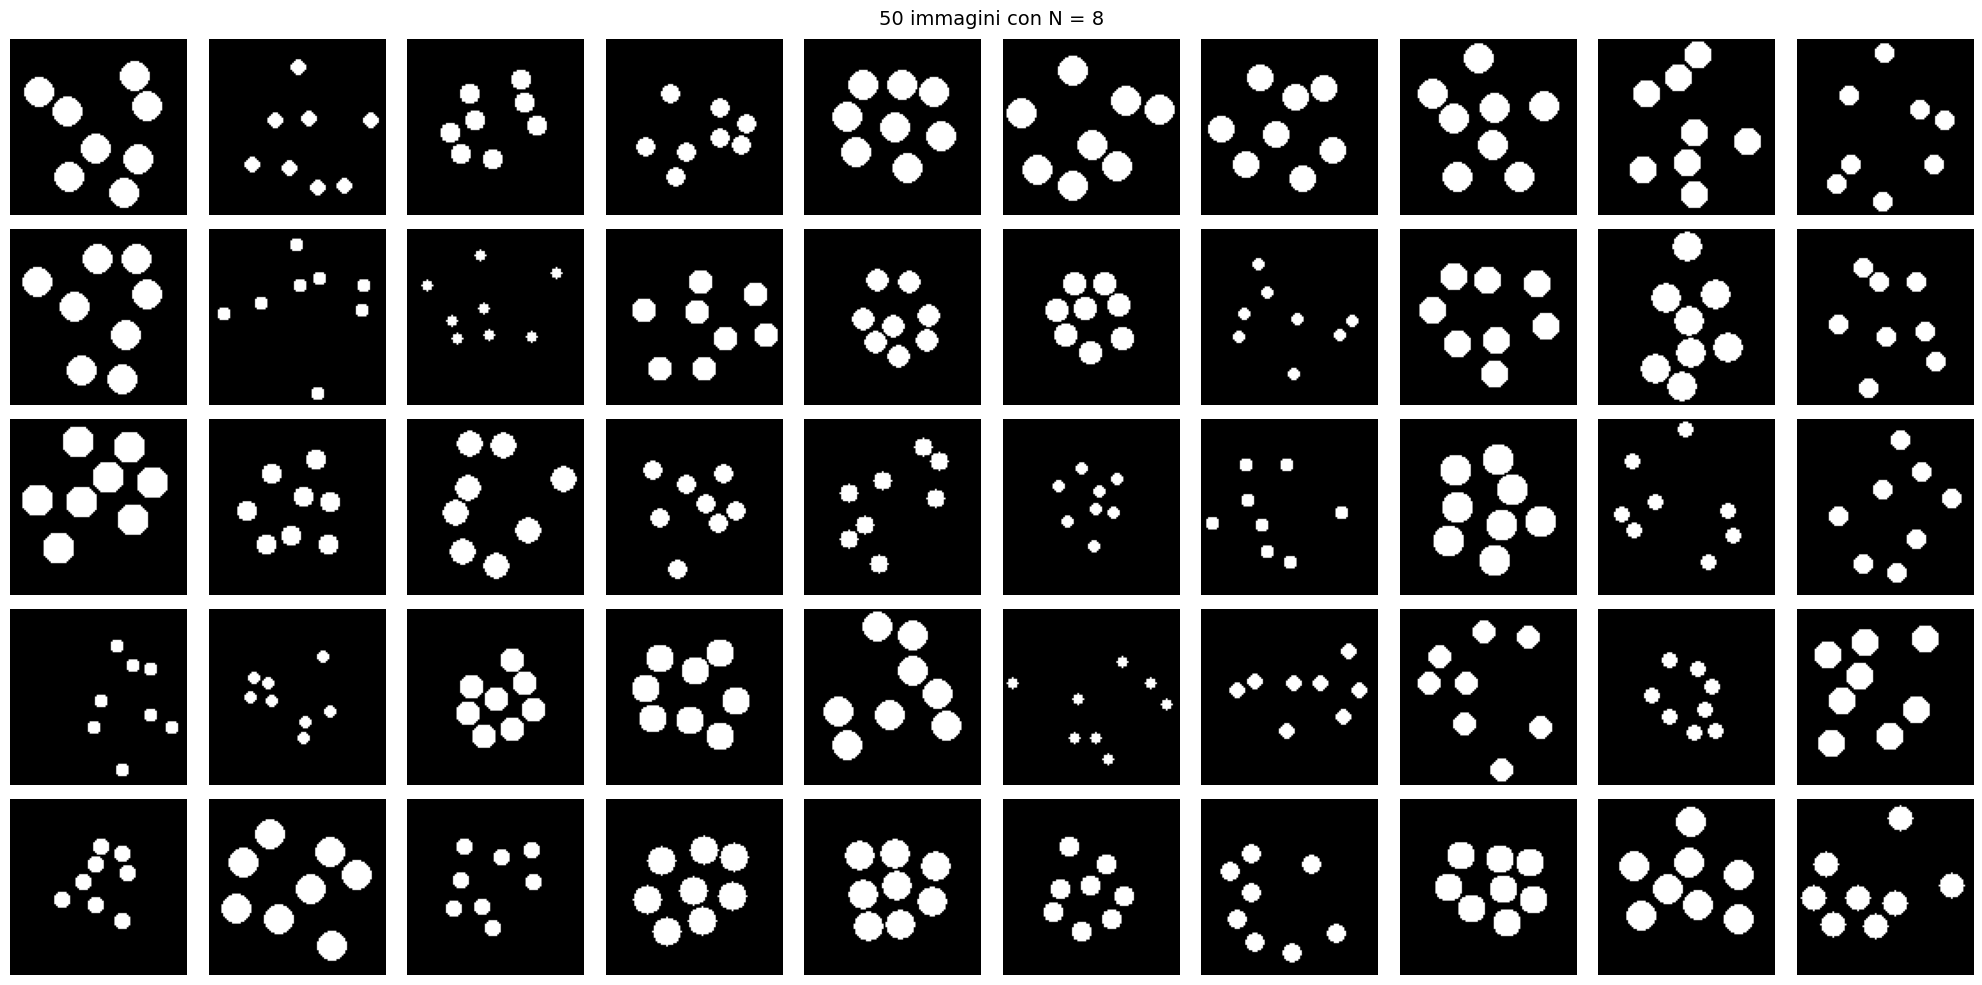

In [4]:
data_path = "circle_dataset_corr_tuned_v12/circle_dataset_100x100_corr_tuned_v12.npz"

plot_label_images(data_path, target_label=8, num_images=50, image_shape=(100, 100))

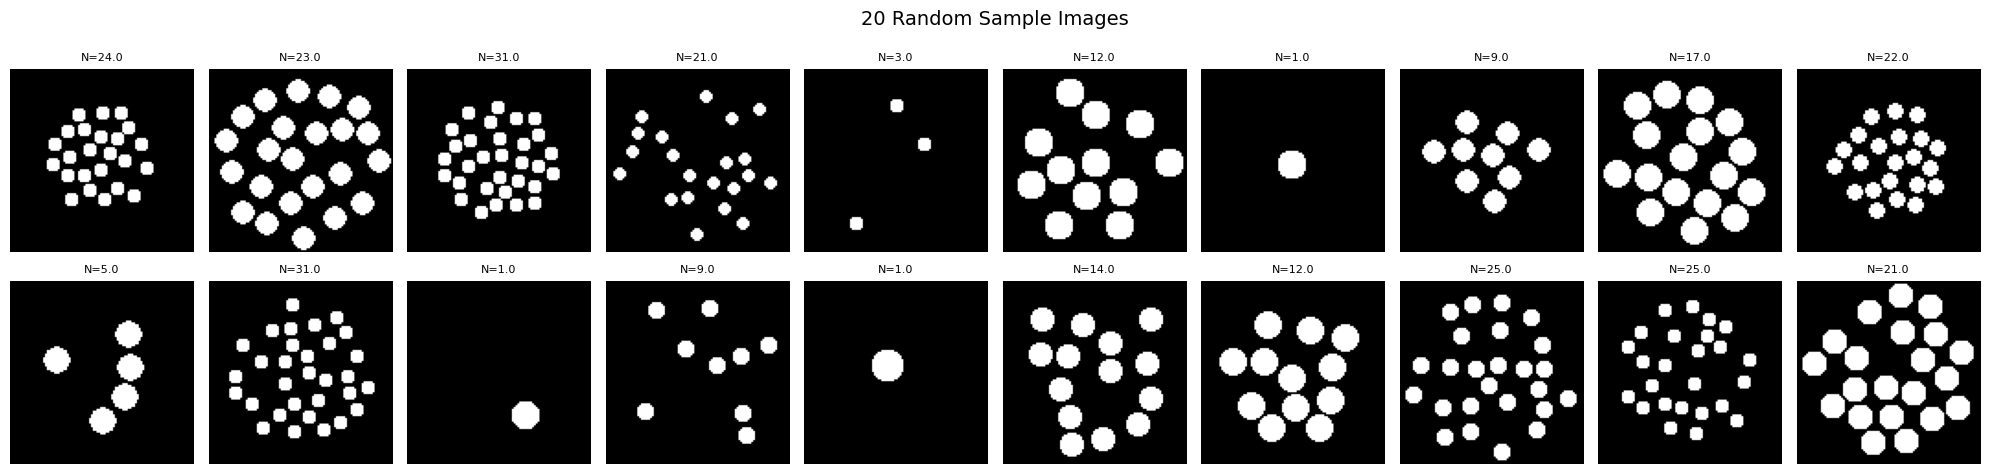

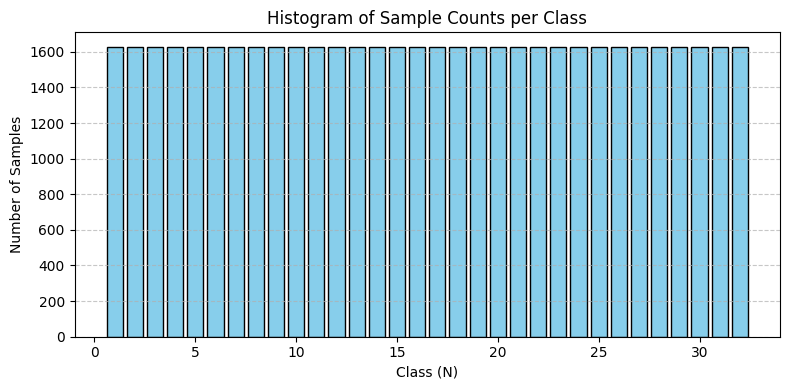

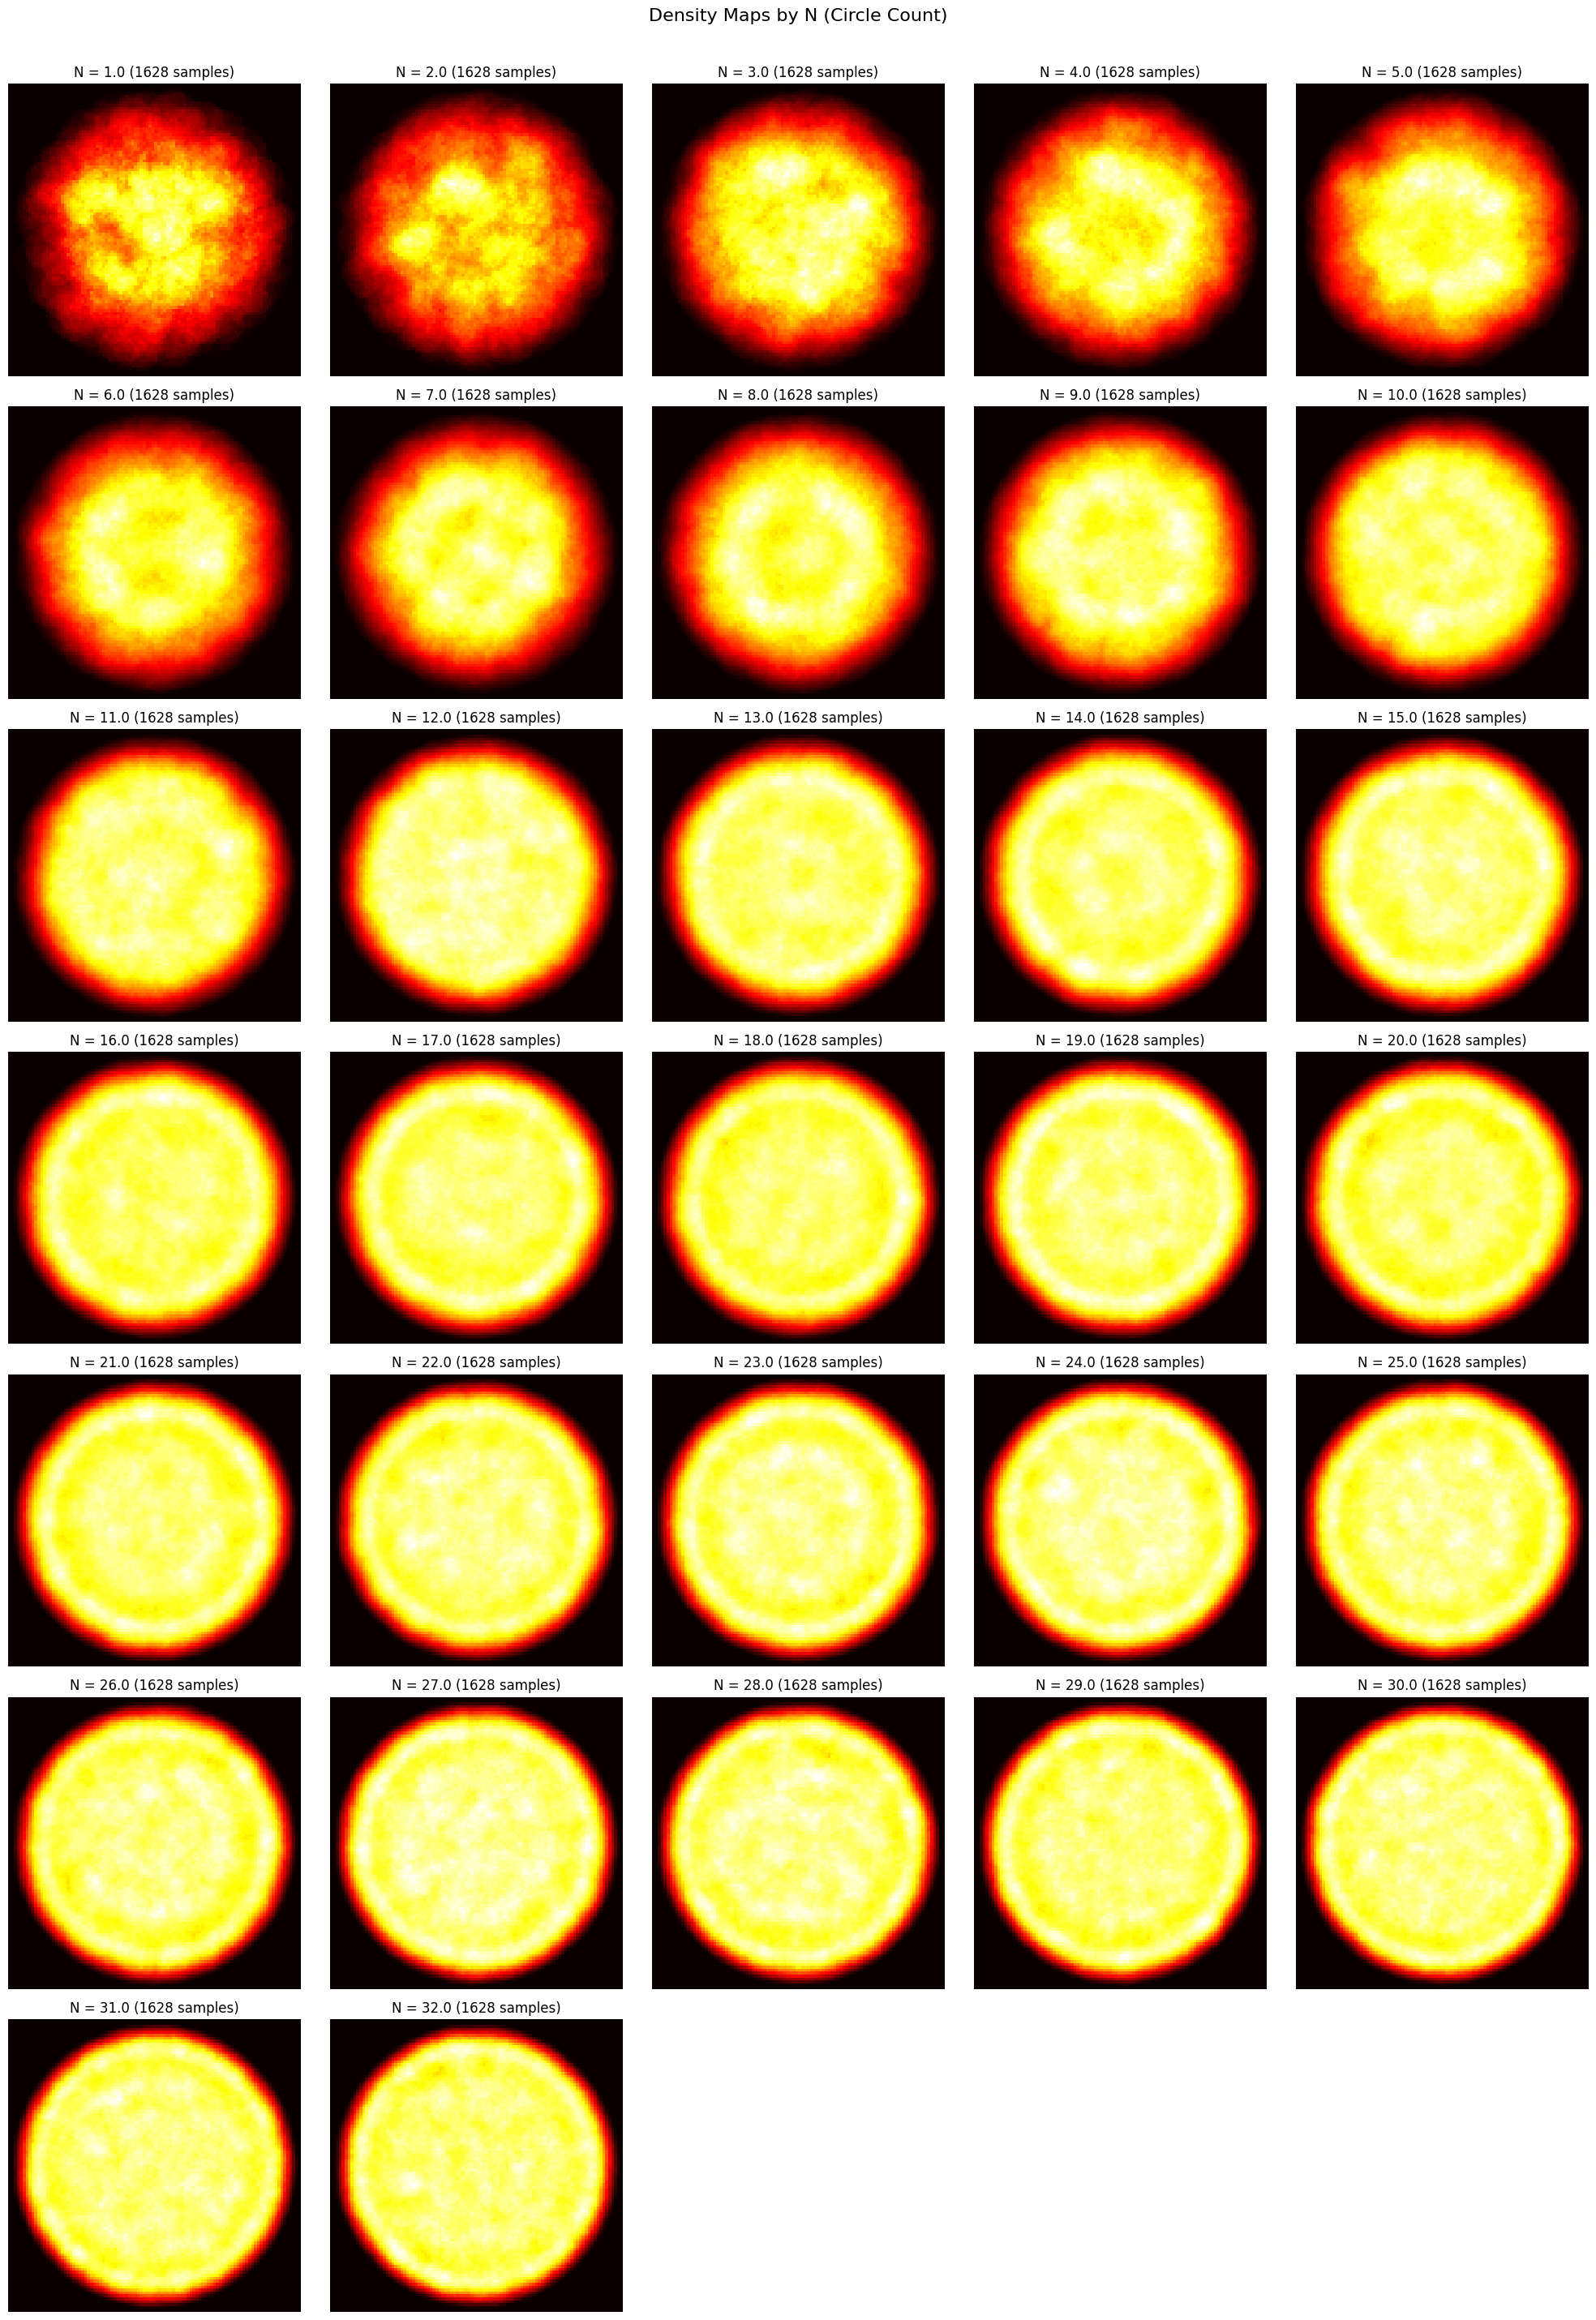

In [13]:
data_path = "circle_dataset_corr_tuned_v12/circle_dataset_100x100_corr_tuned_v12.npz"
plot_all_density_maps(data_path)

In [4]:
from scipy import io
import numpy as np

test_contents = io.loadmat("/home/student/Desktop/Groundeep/NumStim_7to28_100x100_TE.mat")
N_list_test = test_contents['N_list']

In [5]:
np.unique(N_list_test)

array([ 7.,  8.,  9., 10., 11., 12., 14., 16., 18., 20., 22., 25., 28.],
      dtype=float32)